In [6]:
from utils.model import light
from torch import nn

In [ ]:

import torch
from torch._tensor import Tensor


class MLP(light.ModernModule):
    def __init__(self, config: light.ModelConfig):
        super().__init__(config)
        self._is_classification = True
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(config.num_hiddens),
            
            nn.ReLU(),
            nn.LazyLinear(config.output_size),
        )
        
    def compute_loss(self, y_hat, y) -> Tensor:
        return nn.functional.cross_entropy(y_hat, y)
    
    def predict(self, x: Tensor):
        return self.net(x).argmax(dim=1)
    
    def predict_class(self, x: Tensor) -> Tensor:
        return self.predict(x).item()
    
    def evaluate(self, X, y):
        # 评估模型性能
        # 整体正确率 - FP - FN - F1score - AUC
        with torch.no_grad():
            y_hat = self.net(X)
            loss = self.compute_loss(y_hat, y)
            predicted_class = self.predict(X)
            accuracy = (predicted_class == y).float().mean().item()
            return {
                "loss": loss.item(),
                "accuracy": accuracy,
                "predicted_class": predicted_class,
            }

In [8]:
# 数据准备
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
datapath = "../../data/"

transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,))
])

# 加载数据集
fashion_mnist_train = datasets.FashionMNIST(
    root=datapath, train=True, download=True, transform=transformer
)
fashion_mnist_test = datasets.FashionMNIST(
    root=datapath, train=False, download=True, transform=transformer
)

# 创建标准数据加载器 - 无需GPU包装器！
train_loader = DataLoader(
    fashion_mnist_train, 
    batch_size=64, 
    shuffle=True, 
)
val_loader = DataLoader(
    fashion_mnist_test, 
    batch_size=64, 
    shuffle=False, 
)

num_classes = len(fashion_mnist_train.classes)
print(f"数据集类别数: {num_classes}")

数据集类别数: 10


In [9]:
config_mlp = light.ModelConfig(
    lr=0.01,
    num_hiddens=256,
    output_size=num_classes,
    optimizer="sgd",
)

model_ = MLP(config_mlp)
model_.to("cuda" if torch.cuda.is_available() else "cpu")
print(model_.device)

cuda:0


In [25]:
# 移植后的使用方式
import numpy as np
from scipy.stats import rankdata
# from infonet.infer_light import load_lightning_model, load_lightning_model_alternative
from infonet.infer import load_model

# 加载预训练模型
config_path = "../../configs/infonet/config.yaml"
ckpt_path = "../../data/checkpoint/infonet_cp/model_5000_32_1000-720--0.16.pt"

# try:
model = load_model(config_path, ckpt_path)
print("✅ 使用主要方法成功加载模型")
# except Exception as e:
    # print(f"❌ 主要方法失败: {e}")
    # print("🔄 尝试备用方法...")
    # model = load_lightning_model_alternative(config_path, ckpt_path)
    # print("✅ 使用备用方法成功加载模型")
    # print(f"❌ 加载模型失败: {e}")
# model.device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")
model = model.to(device)

✅ 使用主要方法成功加载模型
使用设备: cuda


In [33]:
import m3logpy
import pytorch_lightning as pl
from infonet.infer import compute_smi_mean

import csv
import os
filepath = "mlp.log"

logger = m3logpy.M3Log(file_path=filepath)


class DemoCallBack(pl.Callback):
    def __init__(self, mi_model, csv_path="mi_epoch.csv"):
        super().__init__()
        self.features = {}
        self.mi_model = mi_model
        self.csv_path = csv_path
        # 写入表头
        if not os.path.exists(self.csv_path):
            with open(self.csv_path, "w", newline="") as f:
                writer = csv.writer(f)
                writer.writerow(["epoch", "Flatten-ReLU", "ReLU-Output"])

    def get_activation(self, name):
        def hook(model, input, output):
            self.features[name] = output.detach().cpu()
        return hook

    def on_fit_start(self, trainer, pl_module):
        pl_module.net[0].register_forward_hook(self.get_activation("Flatten"))  # type: ignore
        pl_module.net[2].register_forward_hook(self.get_activation("ReLU"))     # type: ignore
        pl_module.net[3].register_forward_hook(self.get_activation("Output"))   # type: ignore

    def compute_and_log_mi(self, x, y, name):
        # x, y: torch.Tensor
        x = x.numpy().reshape(x.shape[0], -1)
        y = y.numpy().reshape(y.shape[0], -1)
        mi = compute_smi_mean(x, y, self.mi_model, proj_num=1024, seq_len=min(len(x), 2000), batchsize=16)
        logger.info(f"本epoch {name} 互信息: {mi:.4f}")
        return mi

    def on_train_epoch_end(self, trainer, pl_module):
        feat_flatten = self.features.get("Flatten")
        feat_relu = self.features.get("ReLU")
        feat_out = self.features.get("Output")
        epoch = trainer.current_epoch

        if feat_flatten is not None and feat_relu is not None and feat_out is not None:
            mi_flatten_relu = self.compute_and_log_mi(feat_flatten, feat_relu, "Flatten与ReLU")
            mi_relu_output = self.compute_and_log_mi(feat_relu, feat_out, "ReLU与Output")
            # 保存到csv
            with open(self.csv_path, "a", newline="") as f:
                writer = csv.writer(f)
                writer.writerow([epoch, mi_flatten_relu, mi_relu_output])
        else:
            logger.info("未获取到全部激活，无法计算互信息。")
        
        
trainer = light.TrainerFactory.basic(
    max_epochs=20,
)


In [ ]:

import torch
import pytorch_lightning as pl
from pytorch_lightning.utilities import rank_zero_only  # 保证只有主进程执行IO操作

class DemoCallBack_1(pl.Callback):
    def __init__(self, mi_model, csv_path="mi_epoch.csv", max_batches_for_mi=100):
        """
        Args:
            mi_model: 用于计算互信息的预训练模型。
            csv_path (str): 保存结果的CSV文件路径。
            max_batches_for_mi (int): 每个epoch中用于计算MI的最大批次数，以防止内存溢出。
        """
        super().__init__()
        self.features = {}
        self.mi_model = mi_model
        self.csv_path = csv_path
        self.max_batches_for_mi = max_batches_for_mi

        # 用于累积数据的列表
        self.inputs_X_for_mi = []
        self.activations_relu_for_mi = []
        
        # --- 新增的存储列表 ---
        # 如果您还想计算 I(T1; T2)，也需要为它们创建列表
        self.activations_flatten_for_mi = []
        self.activations_output_for_mi = []

        # 写入表头 (使用 rank_zero_only 避免多GPU时重复写入)
        if rank_zero_only.rank == 0 and not os.path.exists(self.csv_path):
            with open(self.csv_path, "w", newline="") as f:
                writer = csv.writer(f)
                # 在表头中加入 I(X;T)
                writer.writerow(["epoch", "I(X;ReLU)", "I(Flatten;ReLU)", "I(ReLU;Output)"])

    def get_activation(self, name):
        def hook(model, input, output):
            self.features[name] = output.detach().cpu()
        return hook

    def on_fit_start(self, trainer, pl_module):
        # 注册钩子以捕获中间层激活
        pl_module.net[0].register_forward_hook(self.get_activation("Flatten")) # type: ignore
        pl_module.net[2].register_forward_hook(self.get_activation("ReLU")) # type: ignore
        pl_module.net[3].register_forward_hook(self.get_activation("Output")) # type: ignore

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        """
        在每个训练批次结束后被调用。
        我们在这里收集输入数据X和中间激活T。
        """
        # 只在主进程中执行，并且只收集指定数量的批次
        if trainer.global_rank != 0 or batch_idx >= self.max_batches_for_mi:
            return

        # 从 batch 中解包输入 X
        # 假设 batch 是一个元组 (inputs, labels)
        x, y = batch
        
        # 检查 self.features 是否包含了当前批次的激活
        feat_relu = self.features.get("ReLU")
        if feat_relu is not None:
            self.inputs_X_for_mi.append(x.cpu())
            self.activations_relu_for_mi.append(feat_relu)
        
        # 如果您还想计算 I(T1; T2)，也在这里收集
        feat_flatten = self.features.get("Flatten")
        feat_out = self.features.get("Output")
        if feat_flatten is not None:
            self.activations_flatten_for_mi.append(feat_flatten)
        if feat_out is not None:
            self.activations_output_for_mi.append(feat_out)


    def compute_and_log_mi(self, x, y, name):
        # x, y: torch.Tensor
        # 确保数据在CPU上，并转换为numpy
        x = x.cpu().numpy().reshape(x.shape[0], -1)
        y = y.cpu().numpy().reshape(y.shape[0], -1)
        
        # 使用您的互信息计算函数
        mi = compute_smi_mean(x, y, self.mi_model, proj_num=1024, seq_len=min(len(x), 2000), batchsize=16)
        logger.info(f"本epoch {name} 互信息: {mi:.4f}")
        return mi

    def on_train_epoch_end(self, trainer, pl_module):
        """
        在训练的epoch结束后，计算并记录累积数据的互信息。
        """
        # 只在主进程中执行计算和写入操作
        if trainer.global_rank != 0:
            return

        epoch = trainer.current_epoch

        # 检查是否收集到了数据
        if not self.inputs_X_for_mi or not self.activations_relu_for_mi:
            logger.warn(f"Epoch {epoch}: 未收集到足够的数据来计算互信息。")
            return

        # 将累积的批次数据拼接成一个大张量
        all_X = torch.cat(self.inputs_X_for_mi, dim=0)
        all_T_relu = torch.cat(self.activations_relu_for_mi, dim=0)
        all_T_flatten = torch.cat(self.activations_flatten_for_mi, dim=0)
        all_T_output = torch.cat(self.activations_output_for_mi, dim=0)

        # 1. 计算 I(X; T_relu)
        mi_x_relu = self.compute_and_log_mi(all_X, all_T_relu, "Input(X) 与 ReLU(T)")
        
        # 2. 计算 I(T1; T2)
        mi_flatten_relu = self.compute_and_log_mi(all_T_flatten, all_T_relu, "Flatten与ReLU")
        mi_relu_output = self.compute_and_log_mi(all_T_relu, all_T_output, "ReLU与Output")

        # 3. 保存到CSV
        with open(self.csv_path, "a", newline="") as f:
            writer = csv.writer(f)
            writer.writerow([epoch, mi_x_relu, mi_flatten_relu, mi_relu_output])

        # 4. 清空列表，为下一个epoch做准备
        self.inputs_X_for_mi.clear()
        self.activations_relu_for_mi.clear()
        self.activations_flatten_for_mi.clear()
        self.activations_output_for_mi.clear()
        
        logger.info(f"Epoch {epoch}: 互信息计算和记录完成。")

In [34]:

trainer.add_callback(DemoCallBack(
    mi_model=model
))

In [35]:
trainer.fit(
    model=model_,
    train_loader=train_loader,
    val_loader=val_loader,
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 203 K  | train
--------------------------------------------
203 K     Trainable params
0         Non-trainable params
203 K     Total params
0.814     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 938/938 [00:21<00:00, 43.20it/s, v_num=2, train_loss=0.248, train_acc=0.844, val_loss=0.356, val_acc=0.876]@2025-06-30T15:35:03Z  #INFO: 本epoch Flatten与ReLU 互信息: 0.2695
@2025-06-30T15:35:07Z  #INFO: 本epoch ReLU与Output 互信息: 0.3917
Epoch 1: 100%|██████████| 938/938 [00:21<00:00, 43.67it/s, v_num=2, train_loss=0.236, train_acc=0.906, val_loss=0.357, val_acc=0.873] @2025-06-30T15:35:33Z  #INFO: 本epoch Flatten与ReLU 互信息: 0.2701
@2025-06-30T15:35:38Z  #INFO: 本epoch ReLU与Output 互信息: 0.4230
Epoch 2: 100%|██████████| 938/938 [00:20<00:00, 46.68it/s, v_num=2, train_loss=0.145, train_acc=0.938, val_loss=0.351, val_acc=0.875]@2025-06-30T15:36:03Z  #INFO: 本epoch Flatten与ReLU 互信息: 0.2826
@2025-06-30T15:36:07Z  #INFO: 本epoch ReLU与Output 互信息: 0.3931
Epoch 3: 100%|██████████| 938/938 [00:24<00:00, 38.62it/s, v_num=2, train_loss=0.349, train_acc=0.844, val_loss=0.348, val_acc=0.874]@2025-06-30T15:36:36Z  #INFO: 本epoch Flatten与ReLU 互信息: 0.2651
@2025-06-30T15:36:41Z  #INFO: 本epoch

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 938/938 [00:40<00:00, 23.25it/s, v_num=2, train_loss=0.481, train_acc=0.812, val_loss=0.357, val_acc=0.871]


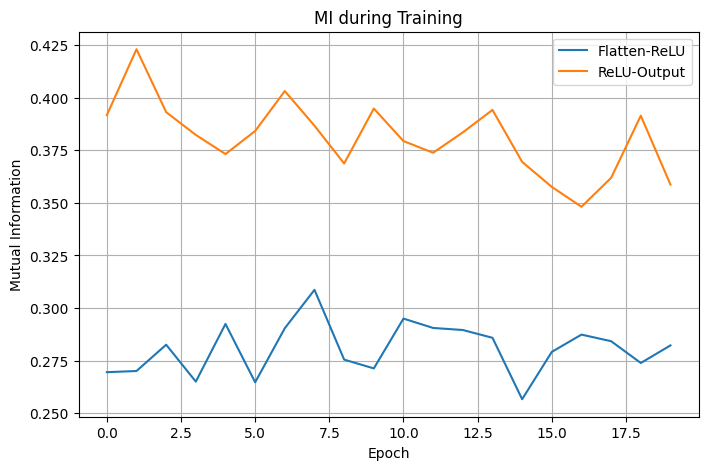

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取CSV
df = pd.read_csv("mi_epoch.csv")

plt.figure(figsize=(8, 5))
plt.plot(df["epoch"], df["Flatten-ReLU"], label="Flatten-ReLU")
plt.plot(df["epoch"], df["ReLU-Output"], label="ReLU-Output")
plt.xlabel("Epoch")
plt.ylabel("Mutual Information")
plt.title("MI during Training")
plt.legend()
plt.grid(True)
plt.show()